In [29]:
import csv
path = r"C:\Users\江炳青\Desktop\Customers.csv"
f = open(path, "r")
reader = csv.reader(f)

content = []
for row in reader:
    content.append(row)
f.close()
print (content[:10])#先读取部分信息观察概貌

[['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)'], ['1', 'Male', '19', '15', '39'], ['2', 'Male', '21', '15', '81'], ['3', 'Female', '20', '16', '6'], ['4', 'Female', '23', '16', '77'], ['5', 'Female', '31', '17', '40'], ['6', 'Female', '22', '17', '76'], ['7', 'Female', '35', '18', '6'], ['8', 'Female', '23', '18', '94'], ['9', 'Male', '64', '19', '3']]


In [17]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

#设置全部列显示和浮点数格式
pd.options.display.max_columns=None
pd.set_option('display.float_format',lambda x:'%.6f'%x)

#数据读取
df=pd.read_csv(open(r"C:\Users\江炳青\Desktop\Customers.csv"),encoding='utf-8',index_col=0)
#为了方便分析数据，需要重新定义列名
df=df.rename(columns={'Gender':'gender','Age':'age','Annual Income (k$)':'annual_income','Spending Score (1-100)':'spending_score'})
df.gender.replace(['Male','Female'],[1,0],inplace=True)#用数字表示性别
df.head(10) #前十个

,gender,age,annual_income,spending_score
CustomerID,,,,
1,1,19,15,39
2,1,21,15,81
3,0,20,16,6
4,0,23,16,77
5,0,31,17,40
6,0,22,17,76
7,0,35,18,6
8,0,23,18,94
9,1,64,19,3


In [18]:
#计算出数据的均值和标准差
dfms=pd.concat([df.mean().to_frame(),df.std().to_frame()],axis=1).transpose()
dfms.index=['mean','std']
#数据标准化
df_scaled=pd.DataFrame()
for i in df.columns:
    if (i=='gender'): df_scaled[i]=df[i]
    else:
        df_scaled[i]=(df[i] - dfms.loc['mean', i]) / dfms.loc['std', i]
df_scaled.head()

,gender,age,annual_income,spending_score
CustomerID,,,,
1,1,-1.421003,-1.734646,-0.433713
2,1,-1.277829,-1.734646,1.192711
3,0,-1.349416,-1.696572,-1.711618
4,0,-1.134655,-1.696572,1.037814
5,0,-0.561958,-1.658498,-0.394989


In [19]:
#按照男女划分
dff=df_scaled.loc[df_scaled.gender==0].iloc[:,1:]
dfm=df_scaled.loc[df_scaled.gender==1].iloc[:,1:]
#选择最优的质心点数
def numbers_of_clusters(df):
    wcss=[]
    for i in range(1,20):
        km=KMeans(n_clusters=i,random_state=0)
        km.fit(df)
        wcss.append(km.inertia_)#用来评估簇的个数是否合适
    df_elbow=pd.DataFrame(wcss)
    df_elbow=df_elbow.reset_index()
    df_elbow.columns=['n_clusters','within_cluster_sum_of_square']
    return df_elbow
#生成质心点
dff_elbow=numbers_of_clusters(dff)
dfm_elbow=numbers_of_clusters(dfm)
dfm_elbow

,n_clusters,within_cluster_sum_of_square
0,0,298.343536
1,1,189.140271
2,2,133.967734
3,3,92.696214
4,4,78.464303
5,5,65.609109
6,6,54.424631
7,7,48.026781
8,8,40.553679
9,9,35.218764


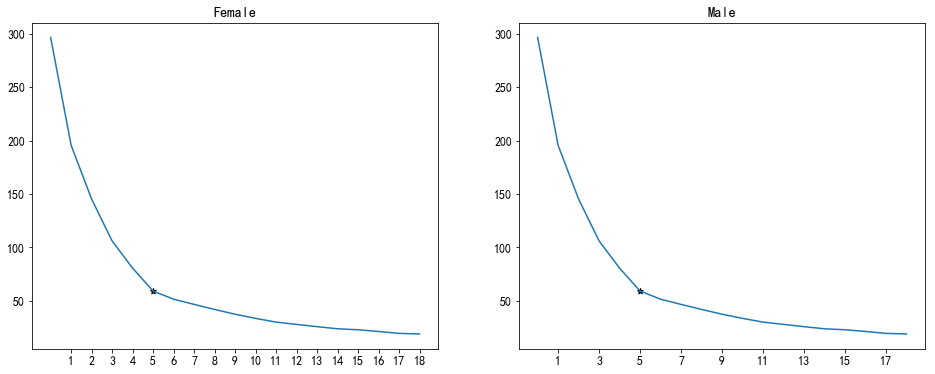

In [22]:
#绘制折线图，选择方差最小值对应的质心点数
plt.subplot(1,2,1)
matplotlib.rcParams['font.family']='SimHei'
matplotlib.rcParams['figure.figsize']=(16,10)
matplotlib.rcParams['font.size']=12
plt.plot(dff_elbow.n_clusters,dff_elbow.within_cluster_sum_of_square)
plt.xticks(range(1,19,1))
plt.title('Female')
plt.scatter(x=dff_elbow.n_clusters[5:6],y=dff_elbow.within_cluster_sum_of_square[5:6],color='black',marker='*')#marker标记方差最小值

plt.subplot(1,2,2)
matplotlib.rcParams['font.family']='SimHei'
matplotlib.rcParams['figure.figsize']=(16,6)
matplotlib.rcParams['font.size']=12
plt.plot(dfm_elbow.n_clusters,dff_elbow.within_cluster_sum_of_square)
plt.xticks(range(1,19,2))
plt.title('Male')
plt.scatter(x=dfm_elbow.n_clusters[5:6],y=dff_elbow.within_cluster_sum_of_square[5:6],color='black',marker='*')

In [30]:
def k_means(n_clusters,df,gender):
    kmf=KMeans(n_clusters=n_clusters,random_state=0)
    kmf.fit(df)
    centroids=kmf.cluster_centers_
    cdf=pd.DataFrame(centroids,columns=df.columns)
    cdf['gender']=gender
    cdf['count']=pd.Series(kmf.labels_).value_counts()
    return cdf
#选择5作为数据的质心点数
df1=k_means(5,dfm,'Male')
df2=k_means(5,dff,'Female')
dfc_scaled=pd.concat([df1,df2],axis=0)
dfc_scaled

,age,annual_income,spending_score,gender,count
0,1.280745,-0.035423,-0.285987,Male,27
1,-0.398899,1.010904,1.257252,Male,18
2,-1.019493,-0.756313,0.436744,Male,23
3,1.191924,-1.391981,-1.511542,Male,6
4,-0.362537,1.006674,-1.545656,Male,14
0,0.982586,-0.497822,-0.308152,Female,33
1,-0.766845,-0.370551,-0.297510,Female,29
2,-0.451324,0.940910,1.176869,Female,22
3,-0.958440,-1.327549,1.174838,Female,13
4,0.411626,1.209734,-1.107517,Female,15


In [24]:
#数据非标准化
dfc=pd.DataFrame()
for i in dfc_scaled.columns:
    if (i=='gender'):dfc[i]=dfc_scaled[i]
    elif (i=='count'):dfc[i]=dfc_scaled[i]
    else:
        dfc[i]=(dfc_scaled[i]*dfms.loc['std',i]+dfms.loc['mean',i])
        dfc[i]=dfc[i].astype(int)
dfc

,age,annual_income,spending_score,gender,count
0,56,59,42,Male,27
1,33,87,82,Male,18
2,24,40,61,Male,23
3,55,24,11,Male,6
4,33,87,10,Male,14
0,52,47,42,Female,33
1,28,50,42,Female,29
2,32,85,80,Female,22
3,25,25,80,Female,13
4,44,92,21,Female,15


In [25]:
#分类1
import sys
a_i=dfms.loc['mean']['annual_income']
s_s=dfms.loc['mean']['spending_score']
dfcm=dfc[dfc['gender']=='Male']
remark=['年长/有孩子的收入一般的潜在男性客户','中年/有孩子的收入较高的优质男客户','年轻的收入一般的潜力男客户','年长/有孩子的收入较低的男客户','中年/有孩子的收入较高的潜在男客户']
dfcm['type']=pd.Series(remark)
dfcm

D:\python jupter notebook\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,age,annual_income,spending_score,gender,count,type
0,56,59,42,Male,27,年长/有孩子的收入一般的潜在男性客户
1,33,87,82,Male,18,中年/有孩子的收入较高的优质男客户
2,24,40,61,Male,23,年轻的收入一般的潜力男客户
3,55,24,11,Male,6,年长/有孩子的收入较低的男客户
4,33,87,10,Male,14,中年/有孩子的收入较高的潜在男客户


In [26]:
#分类2
import sys
a_i=dfms.loc['mean']['annual_income']
s_s=dfms.loc['mean']['spending_score']
dfcf=dfc[dfc['gender']=='Female']
remark=['年长/有孩子的收入一般的潜在女性客户','年轻的收入一般的潜力女客户','中年/有孩子的收入较高的优质女客户','年轻的收入较低的可发展女客户','中年/有孩子的收入较高的一般女客户']
dfcf['type']=pd.Series(remark)
dfcf

D:\python jupter notebook\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,age,annual_income,spending_score,gender,count,type
0,52,47,42,Female,33,年长/有孩子的收入一般的潜在女性客户
1,28,50,42,Female,29,年轻的收入一般的潜力女客户
2,32,85,80,Female,22,中年/有孩子的收入较高的优质女客户
3,25,25,80,Female,13,年轻的收入较低的可发展女客户
4,44,92,21,Female,15,中年/有孩子的收入较高的一般女客户
